## Libraries and modules

In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image

## Initialization of ImageJ

In [ ]:
scyjava.config.add_option('-Xmx30g')
start_dir = os.getcwd()
#ij = imagej.init('sc.fiji:fiji', mode='interactive')
ij = imagej.init('/home/saka/sw/local/fiji/2023', mode='interactive')
## Something about this init() function changes the current working directory.
ij.getApp().getInfo(True)
ij.ui().showUI()
os.chdir(start_dir)
ij.getVersion() #This is to make sure ImageJ/Fiji opened properly. In case of error, it could display '2.9.0/inactive' instead of the full version n

## Import of fiji plugins
This import the ROI manager and associated useful libraries, and z-projector modules.

In [ ]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
ov = Overlay()

## Assignement of parent folder that contains all the subfolders of all your conditions
This opens a dialog window whare you choose the parent folder

In [23]:
root = tk.Tk()
root.withdraw()
directory_path = filedialog.askdirectory()

## generation of the smoothed z-projection "max" of the nuclei channel

In [ ]:
# Z-projection method. Can be change to 'sum' or other as needed. 
method = 'max'

# Get a list of all the folders in the directory
folder_list = os.listdir(directory_path)

# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the czi files in the folder
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)

    # Iterate through the files and apply the image analysis workflow to each image
    for file_path in file_list:
        image = ij.io().open(file_path) # opening the image
        wanted_channel = 0
        blue_channel = image[:, :, wanted_channel,:]

        # Cellpose segmentation for nuclei worked better with a smoothed nuclear signal, specially with low signal. Smoothing workflow :
        sigma = 1.5  # Adjust the value of sigma as needed
        smoothed_image = ij.op().run("smooth", blue_channel, sigma)
        imp = ij.py.to_imageplus(smoothed_image) # convert the image into the imageplus type object needed for z-projection

        # Z-projection
        z_projector_result = ZProjector.run(imp, method)
        z_collapsed_image = ij.py.from_java(z_projector_result)
        z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)  

        # Save as a TIFF image
        result_path = os.path.splitext(file_path)[0] + "_blue.tif"
        ij.io().save(z_collapsed_dataset, result_path)
        print(f"Saving image {result_path}.")

In [ ]:
# Get a list of all the folders in the directory
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*_1airy_1um.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        wanted_channel = 1
        wanted_z = 2
        wanted_image = image[:, :, wanted_channel, wanted_z]
        result_path = os.path.splitext(file_path)[0] + "-1.tif"
        cellpose_image = ij.py.to_dataset(wanted_image)
        ij.io().save(cellpose_image, result_path)
        print(f"Saving image {result_path}.")

## Segmentation and detection of nuclei using Cellpose
For the training of your own model, please follow the training instruction of cellpose GUI, or the youtube tutorial : https://www.youtube.com/watch?v=5qANHWoubZU

Here the model is called "raw" and was obtained from training on the nuclear channel of raw cells. Segmentation results should be manually verified first any time a new cell type is used to ensure the pre-trained or newly trained models are behaving similarly.

NB: "gpu=True" requires having installed the proper libraries. Please look at Cellpose documentation.

In [ ]:
model = models.CellposeModel(gpu=True, model_type='Raw_63x') #change model_type as needed
files = get_image_files(directory_path, '_masks', look_one_level_down=True)
imgs = [imread(f) for f in files]
nimg = len(imgs)
channels = [[0,0]]
masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
io.save_to_png(imgs, masks, flows, files)

### Alternative way of using cellpose, example of segmenting only the images whose path ends by "_blue.tif". 

In [ ]:
#for folder in folder_list:
    # Get the path to the folder
#    folder_path = os.path.join(directory_path, folder)
#    file_pattern = os.path.join(folder_path, "_blue.tif")
#    file_list = glob.glob(file_pattern)
#    model = models.CellposeModel(gpu=True, model_type='sty_fluo_low_8')
#    for file_path in file_list:
#        imgs = io.imread(file_path)
#        channels = [[0,0]]
#        masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
#        io.save_to_png(imgs, masks, flows, file_path)

## Generation of the smooted bacterial channel

In [ ]:
folder_list = os.listdir(directory_path)
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        wanted_channel = 1
        wanted_image = image[:, :, wanted_channel, :]

        sigma = 0.7  # Adjust the value of sigma as needed
        smoothed_image = ij.op().run("smooth", wanted_image, sigma)
        imp = ij.py.to_imageplus(smoothed_image)

        result_path = os.path.splitext(file_path)[0] + "_bact.tif"
        bacteria_image = ij.py.to_dataset(smoothed_image)
        ij.io().save(bacteria_image, result_path)
        print(f"Saving image {result_path}.")

In [ ]:
folder_list = os.listdir(directory_path)
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        wanted_channel = 2
        wanted_image = image[:, :, wanted_channel, :]
        ij.ui().show(wanted_image)
        pretreatment = """
        run("Duplicate...", "duplicate");
        run("Smooth", "stack");
        run("Smooth", "stack");
        """
        smoothed = ij.py.run_macro(pretreatment)
        smoothed_image = ij.py.from_java("-1")
        result_path = os.path.splitext(file_path)[0] + "_bact.tif"
        format = f'Tiff'
        set_string = f'saveAs("{format}", "{result_path}")'
        ij.py.run_macro(set_string)
        ij.py.run_macro("close();")
        ij.py.run_macro("close();")

## Voronoi segmentation on the nuclei channel
This part will open the nuclear channel generated earlier with the associated text file. It then run the voronoi segmentation and save the newly created ROI set.

In [ ]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()

# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the z-projected nuclear files in the folder
    file_pattern = os.path.join(folder_path, "*_blue.tif")
    file_list = glob.glob(file_pattern)



    for file_path in file_list:
        image = ij.io().open(file_path)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_txt = Path(f"{folder_path}/{f_name}_cp_outlines.txt") # opening the corresponding text file to the opened image, from the cellpose output
        txt_fh = open(input_txt, 'r')
        set_string = f'Set Measurements...'
        measure_string = f'centroid redirect=None decimal=1'
        ij.IJ.run(set_string, measure_string)
        roi_stats = defaultdict(list)
        ij.ui().show(image) #to better draw, apply and save ROIs, the image should be displayed
        imp = ij.py.to_imageplus(image) 
        #Call of .txt cellpose output file and draw ROIs based on segmentation result, and add them in the ROI manager
        for line in txt_fh:
            xy = line.rstrip().split(",")
            xy_coords = [int(element) for element in xy]
            x_coords = [int(element) for element in xy[::2]]
            y_coords = [int(element) for element in xy[1::2]]
            xcoords_jint = JArray(JInt)(x_coords)
            ycoords_jint = JArray(JInt)(y_coords)
            polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
            roi_instance = scyjava.jimport('ij.gui.Roi')
            imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
            imp.setRoi(imported_polygon)
            rm.addRoi(imported_polygon)

# The following Macro will first duplicate the opened image, select the nuclear ROIs and reduce them by 1 pixel.
# This is because the function "Analyze Particles..." in ImageJ cannot detect 2 objects separated by 1 pixel.
# All of the ROIs are then selected, filled, and the background remove using "clear outside".
# The resulting image was converted in a binary mask. Particles were detected to collect x,y coordinates and Voronoi segmentation applied. 
# x,y coordinates of objects used as coordinates to apply the magic wand in the Voronoi mesh and create ROIs. 
# The ROI set is saved matching the name of the opened file.


        Macro_voronoi = """
    nbArea=roiManager("count")
for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
		run("Enlarge...", "enlarge=-1 pixel");
		roiManager("update");	
	}

array1 = newArray("0");;
for (i=1;i<roiManager("count");i++){
        array1 = Array.concat(array1,i);
}
	roiManager("select", array1);
	roiManager("XOR");
	roiManager("Fill");
	roiManager("select", array1);
	roiManager("XOR");
	run("Clear Outside");
	roiManager("Delete")
setThreshold(255, 255);
run("Convert to Mask", "method=Default background=Dark black");

//Voronoi ROI generations

run("Set Measurements...", "center redirect=None decimal=1");
	run("Analyze Particles...","size=3-Infinity display clear");
	//Resolution de l'image pwidth et pheight
	getPixelSize(unit, pw, ph, pd);
	//Voronio
	run("Voronoi");
	setThreshold(0, 0,"black & white");
	
	//Wand to ROI Manager
	x=newArray(nResults);
	y=newArray(nResults);
	nbPoints=nResults;
	
	for (i=0; i<nbPoints; i++) {
		x[i]=getResult("XM",i)/pw;
		y[i]=getResult("YM",i)/ph;
	}
	for (i=0; i<nbPoints; i++) {
		doWand(x[i], y[i], 156.0, "Legacy");
		roiManager("Add");
	}

	//Center of mass
	/*
	x=newArray(nResults);
	y=newArray(nResults);
	for (i=0; i<nResults; i++) {
		x[i]=getResult("XM",i)/pw;
		y[i]=getResult("YM",i)/ph;
	}
	*/
	makeSelection("point", x, y);
    selectWindow("Results");
    run("Close");
    close("*");
    """
        ij.py.run_macro(Macro_voronoi)   
        rm.runCommand("Select All")
        rm.runCommand("Save", f"{folder_path}/" + f"{f_name}.zip") # this saves the ROIs as a zip file
        rm.runCommand("Delete")

This part renames the Roi sets to match the name the "bact" file called for the quantification

In [ ]:
folder_list = os.listdir(directory_path)
# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_prefix = "Experiment-"  # Specify the common prefix of the files. Change it as your basic file is formatted.

# Regular expression pattern to match the number in the filename
    pattern = re.compile(rf"{file_prefix}(\d+)_blue\.zip", re.IGNORECASE)

# Iterate over the files in the folder
    for filename in os.listdir(folder_path):
    # Check if the file matches the desired pattern
        match = pattern.match(filename)
        if match:
        # Extract the number from the filename
            current_number = int(match.group(1))
        # Construct the new filename with the updated number
            new_filename = f"{file_prefix}{current_number}_bact.zip"
        # Create the full file paths for the old and new filenames
            old_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)
        # Rename the file
            os.rename(old_filepath, new_filepath)
            print(f"Renamed file: {filename} -> {new_filename}")

The next cell is in case of use of cellpose for segmentation of cells. 

In [ ]:
rm = ij.RoiManager.getRoiManager()
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*-1.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image_red = ij.io().open(file_path)
        imp = ij.py.to_imageplus(image_red)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_txt = Path(f"{folder_path}/{f_name}_cp_outlines.txt")
        txt_fh = open(input_txt, 'r')
        for line in txt_fh:
            xy = line.rstrip().split(",")
            xy_coords = [int(element) for element in xy if element not in '']
            x_coords = [int(element) for element in xy[::2] if element not in '']
            y_coords = [int(element) for element in xy[1::2] if element not in '']
            xcoords_jint = JArray(JInt)(x_coords)
            ycoords_jint = JArray(JInt)(y_coords)
            polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
            roi_instance = scyjava.jimport('ij.gui.Roi')
            imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
            imp.setRoi(imported_polygon)
            rm.addRoi(imported_polygon)
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Save", f"{folder_path}/" + f"{f_name}.zip")
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Delete")

## Quantification of total area per Voronoi ROI and per slice in the z-stack
This step opens the "bact" z-stack with the associated Voronoi ROI set. The macro will then cycle through each single ROI and collect the total area per z using the "analyze particles..." > summarize function. The generated table is then saved as a CSV

In [ ]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()

# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*_bact.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        ij.ui().show(image)
        imp = ij.py.to_imageplus(image)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_ROI = Path(f"{folder_path}/RoiSet.zip")
        rm.open(f"{input_ROI}")
        Measure = """
        setAutoThreshold("Default dark no-reset");
        run("Threshold...");
        setThreshold(25, 255);
        setOption("BlackBackground", true);
        run("Convert to Mask", "black");
        run("Set Scale...", "distance=1024 known=202.83 unit=µm");
        nbArea=roiManager("count")
        for (i=0; i<nbArea; i++) {
				roiManager("Select", i);
				run("Set Measurements...", "area limit redirect=None decimal=2");
				run("Analyze Particles...", "summarize stack");
        }
        title = Table.title();
        selectWindow(title);
        Table.rename(title, "Results");
        array1 = newArray("0");
        for (i=1;i<roiManager("count");i++){
        array1 = Array.concat(array1,i);
        }
        roiManager("select", array1);
        roiManager("Delete");
        close("*");
        
        """
        ij.py.run_macro(Measure)
        measurements = ij.ResultsTable.getResultsTable() # call of the table
        measurements_table = ij.convert().convert(measurements, scyjava.jimport('org.scijava.table.Table')) # conversion to a java table object
        table = ij.py.from_java(measurements_table) # Conversion into a python dataframe from Java
        results = os.path.basename(file_path)
        results = os.path.splitext(results)[0]
        output_path = Path(f"{folder_path}/{results}.csv") # save giving a name matching the opened image
        table.to_csv(output_path)
        ij.py.run_macro(""" 
        title = Table.title();
        selectWindow(title);
        run("Close");
        """
                       )
        # this last step is to close the result table to avoir a concatenation of the next round of results.

In [ ]:
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "Image_CH3_flatten.tif")
    image_red = ij.io().open(file_pattern)
    imp = ij.py.to_imageplus(image_red)
    input_txt = Path(f"{folder_path}/Image_CH3_flatten_cp_outlines.txt")
    txt_fh = open(input_txt, 'r')
    for line in txt_fh:
        xy = line.rstrip().split(",")
        xy_coords = [int(element) for element in xy if element not in '']
        x_coords = [int(element) for element in xy[::2] if element not in '']
        y_coords = [int(element) for element in xy[1::2] if element not in '']
        xcoords_jint = JArray(JInt)(x_coords)
        ycoords_jint = JArray(JInt)(y_coords)
        polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
        roi_instance = scyjava.jimport('ij.gui.Roi')
        imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
        imp.setRoi(imported_polygon)
        rm.addRoi(imported_polygon)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{folder_path}/" + f"RoiSet.zip")
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Delete")

## Calculation of bacterial volume per cell
The datasets are structured with on column 'Slice', 'Total Area' and other that we are not interested in. The 'slice' column it an repetition of values 1, 2, 3,...,11. Here for the example case, as the slices are separated by 1um, the volume is a simple sum of the values in the column 'total area' in one repetition of slices 1 to 11. The results of that calculation are then stored in the new dataset, and the total results for each condition are pooled the same dataset and saved as a CSV. 

In [ ]:
#df = pandas.read_csv(dataset)
#df = df.rename(columns={'Unnamed: 0': 'cellid'})
#df.head()

In [2]:
def calculate_total_volume_per_cell(df):
    """Calculates the sum of the "Total Area" for each pattern of the "Slice" column.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        A pandas DataFrame containing the sum of the "Total Area" for each pattern of the "Slice" column.
    """

    # Create a list to store the DataFrames with results.
    results = []

    # Loop through the DataFrame.
    for i in range(len(df)):
        # If the current cell value in the "Slice" column is 1,
        if df['Slice'][i] == 1:
            # Sum the "Total Area" column for the next 10 rows.
            #slice_number = 10  # You need to define slice_number and slice_distance
            #slice_distance = 1  # You need to define slice_number and slice_distance
            bacterial_area = df['Total Area'][i:i + slice_number].sum()
            bacterial_volume = bacterial_area * slice_distance
            # Create a DataFrame with the current pattern number and the total area.
            result_df = pandas.DataFrame({'bacterial_volume': [bacterial_volume]}, index=[i])
            results.append(result_df)

    # Concatenate the list of DataFrames to create the final results DataFrame.
    final_results = pandas.concat(results, ignore_index=True)

    # Return the final results DataFrame.
    return final_results

In [36]:
slice_number = 21
slice_distance = 0.5  # Change this to the actual slice distance in your experiment
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the z-projected nuclear files in the folder
    file_pattern = os.path.join(folder_path, "*1airy_05um_bact.csv")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        # Read the DataFrame.
        df = pandas.read_csv(file_path)

        # Calculate the sum of the "Total Area" for each pattern of the "Slice" column.
        df = calculate_total_volume_per_cell(df)


    f_name = os.path.basename(folder_path)
    #f_name = os.path.splitext(f_name)[0]
    output_path = Path(f"{folder_path}/{f_name}_05um.csv")
    df.to_csv(output_path)

## testing area
Test of follow-up quality controls and figure generation

In [59]:
root = tk.Tk()
root.withdraw()
filepath = filedialog.askopenfilename()

In [45]:
print(filepath)

/home/saka/Documents/Lab_stuff/confocal/20230823_sty_cytochalasin_MS/cytoD1_rep1/Experiment-1916_1airy_0.18_bact.csv


In [46]:
slice_number = 56
slice_distance = 0.18 
df = pandas.read_csv(filepath)
df = calculate_total_volume_per_cell(df)
f_name = os.path.basename(filepath)
f_name = os.path.splitext(f_name)[0]
#output_path = Path(f"{directory_path}/UT_rep2/UT_rep2_018um.csv")
#df.to_csv(output_path)

In [47]:
df.head()

,bacterial_volume
0,4.703392
1,0.000000
2,0.000000
3,0.000000
4,0.000000


In [48]:
f_name = os.path.basename(filepath)
f_name = os.path.splitext(f_name)[0]
output_path = Path(f"{directory_path}/cytoD1_rep1/cytoD1_rep1_18um.csv")
df.to_csv(output_path)

In [60]:
df = pandas.read_csv(filepath)
df.head()

,UT_018,CytoD1_018um,cytoD10
0,5.833336,4.703392,1.377119
1,0.000000,0.000000,19.166677
2,2.464691,0.000000,6.701981
3,38.961885,0.000000,0.000000
4,0.614407,0.000000,16.433624


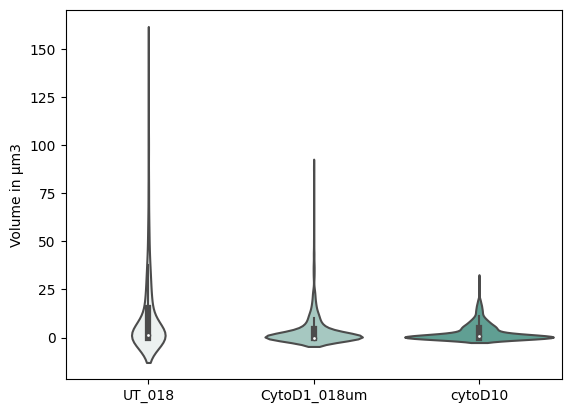

In [61]:
prout = seaborn.violinplot(data=df, width=0.9, dodge=True, palette = "light:#5A9", as_cmap=True)
plt.ylabel('Volume in µm3')
plt.show()

In [62]:
result = Path(f"{directory_path}/plot_volume_diff_018um.tif")
violin = prout.get_figure()
violin.savefig(result)